In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy, mae, mse
import sys
import time
import tensorflow as tf
import os
from tqdm.notebook import tqdm

In [2]:
file_pathes = [x for x in os.listdir() if x.endswith(".csv")]

In [3]:
df = pd.DataFrame()
for path in file_pathes:
    data = pd.read_csv(path, names = ["date", 'time','open','high', 'low','close','volume'])
    df = pd.concat([df, data])

In [4]:
df

,date,time,open,high,low,close,volume
0,2018.01.01,17:00,1.20037,1.20100,1.20037,1.20100,0
1,2018.01.01,17:01,1.20083,1.20095,1.20017,1.20030,0
2,2018.01.01,17:02,1.20035,1.20043,1.20035,1.20043,0
3,2018.01.01,17:03,1.20041,1.20050,1.20031,1.20046,0
4,2018.01.01,17:04,1.20049,1.20049,1.20046,1.20048,0
...,...,...,...,...,...,...,...
15375,2020.05.15,16:54,1.08185,1.08200,1.08182,1.08185,0
15376,2020.05.15,16:55,1.08188,1.08212,1.08185,1.08191,0
15377,2020.05.15,16:56,1.08190,1.08193,1.08179,1.08192,0
15378,2020.05.15,16:57,1.08192,1.08202,1.08181,1.08182,0


In [6]:
# window_size = 60*4
# label = []
# for i, price in tqdm(enumerate(df['close']), total = len(df)):
#     if i > (len(df['close']) - window_size):
#         target = 0
#     else:
#         chunk = list(df['close'][i:(i + window_size)])
#         open_price = chunk[0]
#         target = 0
#         for j,p in enumerate(chunk):
#             target += (window_size - j)**2*(open_price - p)
#     label.append(target)

In [7]:
# label

In [8]:
window_size = 10
label = []
cof = np.array([(window_size - j)**1 for j in range(window_size)])
cof = cof/cof.sum()*10000
close = df['close'].values
for i, price in tqdm(enumerate(df['close']), total = len(df)):
    if i > (len(df['close']) - window_size):
        target = 0
    else:
        chunk = close[i:(i + window_size)]
        open_price = chunk[0]
        close_price = chunk[-1]
        dif = open_price - chunk
#         target = (dif*cof).sum()
        target = (close_price - open_price)*10000
#         for j,p in enumerate(chunk):
#             target += (window_size - j)**2*(open_price - p)
    label.append(target)
#     print(target)
#     break

In [10]:
# label

In [11]:
label = label[1:(len(label) - window_size)]

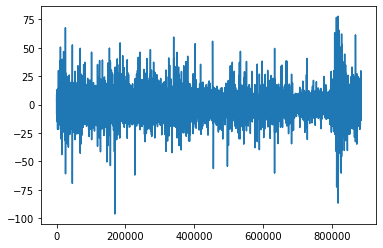

In [12]:
plt.plot(label);

In [13]:
print(np.mean(label), len(label))

-0.012075131235450464 884479


In [ ]:
x = (np.diff(df['close'])*100000)[0:(len(df['close']) - window_size - 1)]

In [220]:
len(x)

884479

In [221]:
split_point = int(len(x)*0.9)
x_t = x[0:split_point]
y_t = label[0:split_point]
x_v = x[split_point:]
y_v = label[split_point:]

In [222]:
print(type(x_t), type(y_t))

<class 'numpy.ndarray'> <class 'list'>


In [223]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [224]:
t_gen = TimeseriesGenerator(data=x_t,targets=y_t, length=24*60, stride = 30, batch_size=2**6)
v_gen = TimeseriesGenerator(data=x_v,targets=y_v, length=24*60, stride = 30, batch_size=32)

In [225]:
t_gen.__len__()

414

In [226]:
from tensorflow.keras.layers import Dense, Input, Conv1D, Reshape, Flatten, LSTM, concatenate
from tensorflow.keras.models import Model

In [256]:
inp = Input(shape=24*60, dtype = tf.float32)
x = Reshape((24*60,1), dtype = tf.float32)(inp)
x = Conv1D(8*2, kernel_size = 10, strides = 3, dtype = tf.float32, activation = 'relu')(x)
x = Conv1D(16*2, kernel_size = 10, strides = 3, dtype = tf.float32, activation = 'relu')(x)
x = Conv1D(32*2, kernel_size = 10, strides = 3, dtype = tf.float32, activation = 'relu')(x)
x = Conv1D(64*2, kernel_size = 10, strides = 3, dtype = tf.float32, activation = 'relu')(x)
# x = Conv1D(128*2, kernel_size = 10, strides = 3, dtype = tf.float32)(x)
# x = Conv1D(64, kernel_size = 10, strides = 3, dtype = tf.float32)(x)
x = LSTM(128, activation=None, return_sequences=True)(x)
x = LSTM(1, activation=None, return_sequences=False)(x)
z = Flatten(dtype = tf.float32)(x)

x = Dense(128, dtype = tf.float32)(z)
x = Dense(64, dtype = tf.float32)(x)
x = Dense(32, dtype = tf.float32)(x)
x = Dense(8, dtype = tf.float32)(x)
x = Dense(1, dtype = tf.float32, name = 'value')(x)


y = Dense(128, dtype = tf.float32)(z)
y = Dense(64, dtype = tf.float32)(y)
y = Dense(32, dtype = tf.float32)(y)
y = Dense(8, dtype = tf.float32)(y)
y = Dense(1, dtype = tf.float32, activation='sigmoid', name='select')(y)
v = concatenate([x,y])
model = Model(inputs = inp, outputs = v)

In [243]:
# def mse_rev(y_true, y_pred):
#     value = y_pred[0]
#     select = y_pred[1]
#     return tf.reduce_sum((y_true - value)**2*select/tf.reduce_mean(y_pred[1]))

In [258]:
def mse_rev(y_true, y_pred):
    w = y_pred[:,1] + 0.001
    l2 = tf.reduce_sum(tf.square(y_true - y_pred[:,0])*w)/tf.reduce_sum(w)
    return l2

In [259]:
model.compile(optimizer='adam', loss=mse_rev)

In [260]:
model.fit(t_gen, validation_data=v_gen, epochs=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 414 steps, validate for 91 steps
Epoch 1/50
414/414 [==============================] - 21s 51ms/step - loss: 870.2212 - val_loss: 1346.4450
Epoch 2/50
414/414 [==============================] - 19s 47ms/step - loss: 850.7607 - val_loss: 1346.7292
Epoch 3/50
414/414 [==============================] - 19s 46ms/step - loss: 850.5793 - val_loss: 1346.4728
Epoch 4/50
414/414 [==============================] - 19s 46ms/step - loss: 850.9956 - val_loss: 1346.5441
Epoch 5/50
414/414 [==============================] - 19s 46ms/step - loss: 850.6892 - val_loss: 1346.4258
Epoch 6/50
 44/414 [==>...........................] - ETA: 16s - loss: 629.0637

KeyboardInterrupt: 

In [232]:
t_gen = TimeseriesGenerator(data=x_t,targets=y_t, length=24*60, stride = 30, batch_size=2**6)

In [233]:
for i in range(t_gen.__len__()):
    x = t_gen.__getitem__(i)
    pred = model(x[0])

    # pred
    print("---------------------------------")
    print(mse_rev(x[1], pred))
    
    print(mse(x[1], pred[:,0]))

---------------------------------
tf.Tensor(9.52605, shape=(), dtype=float32)
tf.Tensor(6.7543507, shape=(), dtype=float32)
---------------------------------
tf.Tensor(11.957442, shape=(), dtype=float32)
tf.Tensor(16.30352, shape=(), dtype=float32)
---------------------------------
tf.Tensor(9.72375, shape=(), dtype=float32)
tf.Tensor(9.756008, shape=(), dtype=float32)
---------------------------------
tf.Tensor(8.228939, shape=(), dtype=float32)
tf.Tensor(7.541732, shape=(), dtype=float32)
---------------------------------
tf.Tensor(15.915688, shape=(), dtype=float32)
tf.Tensor(17.099676, shape=(), dtype=float32)
---------------------------------
tf.Tensor(27.5491, shape=(), dtype=float32)
tf.Tensor(28.360418, shape=(), dtype=float32)
---------------------------------
tf.Tensor(22.140495, shape=(), dtype=float32)
tf.Tensor(26.25045, shape=(), dtype=float32)
---------------------------------
tf.Tensor(27.780312, shape=(), dtype=float32)
tf.Tensor(33.02213, shape=(), dtype=float32)
----

tf.Tensor(16.412395, shape=(), dtype=float32)
tf.Tensor(18.954435, shape=(), dtype=float32)
---------------------------------
tf.Tensor(8.359558, shape=(), dtype=float32)
tf.Tensor(16.849697, shape=(), dtype=float32)
---------------------------------
tf.Tensor(27.526648, shape=(), dtype=float32)
tf.Tensor(23.61586, shape=(), dtype=float32)
---------------------------------
tf.Tensor(24.964987, shape=(), dtype=float32)
tf.Tensor(24.370026, shape=(), dtype=float32)
---------------------------------
tf.Tensor(20.851484, shape=(), dtype=float32)
tf.Tensor(15.973024, shape=(), dtype=float32)
---------------------------------
tf.Tensor(12.545261, shape=(), dtype=float32)
tf.Tensor(12.754611, shape=(), dtype=float32)
---------------------------------
tf.Tensor(42.302994, shape=(), dtype=float32)
tf.Tensor(50.843353, shape=(), dtype=float32)
---------------------------------
tf.Tensor(25.68734, shape=(), dtype=float32)
tf.Tensor(26.325764, shape=(), dtype=float32)
-----------------------------

tf.Tensor(15.357479, shape=(), dtype=float32)
tf.Tensor(32.436962, shape=(), dtype=float32)
---------------------------------
tf.Tensor(20.411936, shape=(), dtype=float32)
tf.Tensor(13.784727, shape=(), dtype=float32)
---------------------------------
tf.Tensor(12.469622, shape=(), dtype=float32)
tf.Tensor(9.967058, shape=(), dtype=float32)
---------------------------------
tf.Tensor(11.200298, shape=(), dtype=float32)
tf.Tensor(15.418295, shape=(), dtype=float32)
---------------------------------
tf.Tensor(14.798087, shape=(), dtype=float32)
tf.Tensor(18.797337, shape=(), dtype=float32)
---------------------------------
tf.Tensor(18.579746, shape=(), dtype=float32)
tf.Tensor(11.175417, shape=(), dtype=float32)
---------------------------------
tf.Tensor(16.516375, shape=(), dtype=float32)
tf.Tensor(11.344694, shape=(), dtype=float32)
---------------------------------
tf.Tensor(9.576679, shape=(), dtype=float32)
tf.Tensor(13.353673, shape=(), dtype=float32)
----------------------------

---------------------------------
tf.Tensor(3.2539861, shape=(), dtype=float32)
tf.Tensor(6.807853, shape=(), dtype=float32)
---------------------------------
tf.Tensor(4.4439383, shape=(), dtype=float32)
tf.Tensor(7.9824343, shape=(), dtype=float32)
---------------------------------
tf.Tensor(7.325039, shape=(), dtype=float32)
tf.Tensor(6.8864136, shape=(), dtype=float32)
---------------------------------
tf.Tensor(7.260894, shape=(), dtype=float32)
tf.Tensor(8.973892, shape=(), dtype=float32)
---------------------------------
tf.Tensor(4.7046914, shape=(), dtype=float32)
tf.Tensor(3.554101, shape=(), dtype=float32)
---------------------------------
tf.Tensor(13.826415, shape=(), dtype=float32)
tf.Tensor(11.695608, shape=(), dtype=float32)
---------------------------------
tf.Tensor(5.336874, shape=(), dtype=float32)
tf.Tensor(8.001146, shape=(), dtype=float32)
---------------------------------
tf.Tensor(13.828084, shape=(), dtype=float32)
tf.Tensor(15.723255, shape=(), dtype=float32)

tf.Tensor(2.9732563, shape=(), dtype=float32)
tf.Tensor(3.1991665, shape=(), dtype=float32)
---------------------------------
tf.Tensor(6.172643, shape=(), dtype=float32)
tf.Tensor(4.251296, shape=(), dtype=float32)
---------------------------------
tf.Tensor(2.637089, shape=(), dtype=float32)
tf.Tensor(24.101269, shape=(), dtype=float32)
---------------------------------
tf.Tensor(3.2447221, shape=(), dtype=float32)
tf.Tensor(3.752225, shape=(), dtype=float32)
---------------------------------
tf.Tensor(2.3341198, shape=(), dtype=float32)
tf.Tensor(3.5341635, shape=(), dtype=float32)
---------------------------------
tf.Tensor(3.261014, shape=(), dtype=float32)
tf.Tensor(4.220169, shape=(), dtype=float32)
---------------------------------
tf.Tensor(9.320394, shape=(), dtype=float32)
tf.Tensor(15.470473, shape=(), dtype=float32)
---------------------------------
tf.Tensor(3.5771968, shape=(), dtype=float32)
tf.Tensor(11.109516, shape=(), dtype=float32)
---------------------------------

tf.Tensor(7.5590563, shape=(), dtype=float32)
tf.Tensor(5.87738, shape=(), dtype=float32)
---------------------------------
tf.Tensor(11.850589, shape=(), dtype=float32)
tf.Tensor(27.9599, shape=(), dtype=float32)
---------------------------------
tf.Tensor(6.0526943, shape=(), dtype=float32)
tf.Tensor(8.105048, shape=(), dtype=float32)
---------------------------------
tf.Tensor(3.0526235, shape=(), dtype=float32)
tf.Tensor(3.710773, shape=(), dtype=float32)
---------------------------------
tf.Tensor(1.6487998, shape=(), dtype=float32)
tf.Tensor(3.5501842, shape=(), dtype=float32)
---------------------------------
tf.Tensor(6.2862363, shape=(), dtype=float32)
tf.Tensor(3.9125109, shape=(), dtype=float32)
---------------------------------
tf.Tensor(2.452943, shape=(), dtype=float32)
tf.Tensor(3.4641137, shape=(), dtype=float32)
---------------------------------
tf.Tensor(0.9538673, shape=(), dtype=float32)
tf.Tensor(2.080911, shape=(), dtype=float32)
---------------------------------


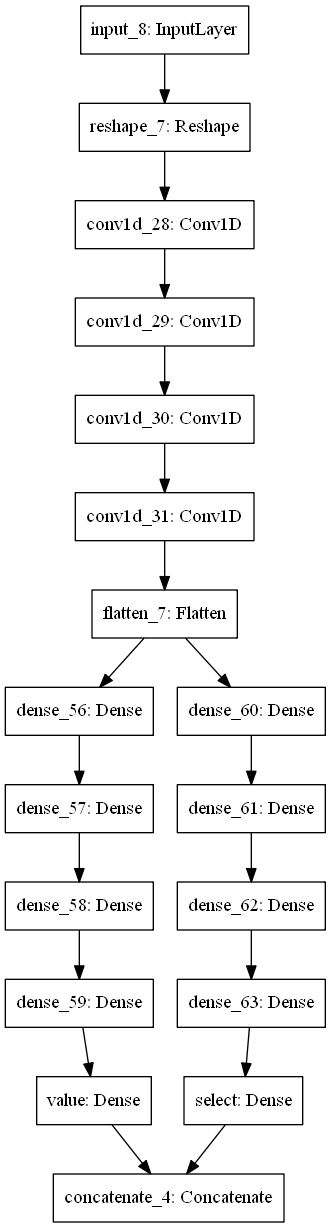

In [160]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [257]:
print(model.summary())

Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 1440)]       0                                            
__________________________________________________________________________________________________
reshape_29 (Reshape)            (None, 1440, 1)      0           input_30[0][0]                   
__________________________________________________________________________________________________
conv1d_151 (Conv1D)             (None, 477, 16)      176         reshape_29[0][0]                 
__________________________________________________________________________________________________
conv1d_152 (Conv1D)             (None, 156, 32)      5152        conv1d_151[0][0]                 
___________________________________________________________________________________________

In [210]:

y_valid = np.array([])
for i in range(v_gen.__len__()):
    chunk = v_gen.__getitem__(i)
#     print(chunk[1])
    y_valid = np.concatenate([y_valid, chunk[1]])

y_train = np.array([])
for i in range(t_gen.__len__()):
    chunk = t_gen.__getitem__(i)
    y_train = np.concatenate([y_train, chunk[1]])

print(mse(y_valid, np.mean(y_train)))

print(mse(y_train, np.mean(y_train)))

tf.Tensor(200.55748269135515, shape=(), dtype=float64)
tf.Tensor(65.92540412600393, shape=(), dtype=float64)


In [211]:
def step(X, y):
    with tf.GradientTape() as tape:
        pred = model(X)
        loss = mse(y, pred)
    grads = tape.gradient(loss, model.trainable_variables)
    return grads

In [186]:
INIT_LR = 1e-3
EPOCHS = 5
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [231]:
EPOCHS = 20
total_steps = EPOCHS*t_gen.__len__()
steps_for_update = int(1/2*t_gen.__len__())
total_updates = total_steps//steps_for_update
counter = 0
cs = 0
for u in range(total_updates):
    for _ in tqdm(range(steps_for_update)):
        i = cs%t_gen.__len__()
        trainX, trainY = t_gen.__getitem__(i)
        if counter == 0:
            grads = step(trainX, trainY)
        else:
            new_grads = step(trainX, trainY)
            grads = [(grads[i]*counter + new_grads[i])/(counter+1) for i in range(len(grads))]
        counter += 1

        if counter == steps_for_update:
            opt.apply_gradients(zip(grads, model.trainable_variables))
            counter = 0
            print('Weights updated at step {} and epoch {}'.format(u, u//t_gen.__len__()));
            print('Model evaluated on valid data:', model.evaluate(v_gen));
            print('Model evaluated on train data:', model.evaluate(t_gen));
        cs += 1

KeyboardInterrupt: 

ValueError: Unable to match target structure and sample_weight_modes structure:
  ...
    to  
  ['...', '...']